In [32]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') 
    # Added payments.csv for specific handling
]


# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    port=3306,
    user='root',
    password='Rajat@2005',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Asus/OneDrive/Desktop/data science/Ecommerce/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as  plt
import seaborn as sns
import mysql.connector
db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="Rajat@2005",
                            database="Ecommerce")
cur=db.cursor()

# List all unique cities where customers are located.    

In [23]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city"])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [25]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 270606)

 # Find the total sales per category.

In [11]:
query="""select products.product_category category,round(sum(payments.payment_value),2) sales
from products join order_items on products.product_id =order_items.product_id
join payments on payments.order_id =order_items.order_id group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,perfumery,7.094341e+07
1,Furniture Decoration,2.002247e+08
2,telephony,6.816349e+07
3,Fashion Bags and Accessories,3.054216e+07
4,bed table bath,2.397575e+08
...,...,...
69,cds music dvds,1.679202e+05
70,La Cuisine,4.078942e+05
71,Fashion Children's Clothing,1.099938e+05
72,PC Gamer,3.044202e+05


# Calculate the percentage of orders that were paid in installments.

In [48]:
query="""select sum(case when payment_installments>=1 then 1 else 0 end )/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
"The percentage of orders that were paid in installments is ",data[0][0]

('The percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

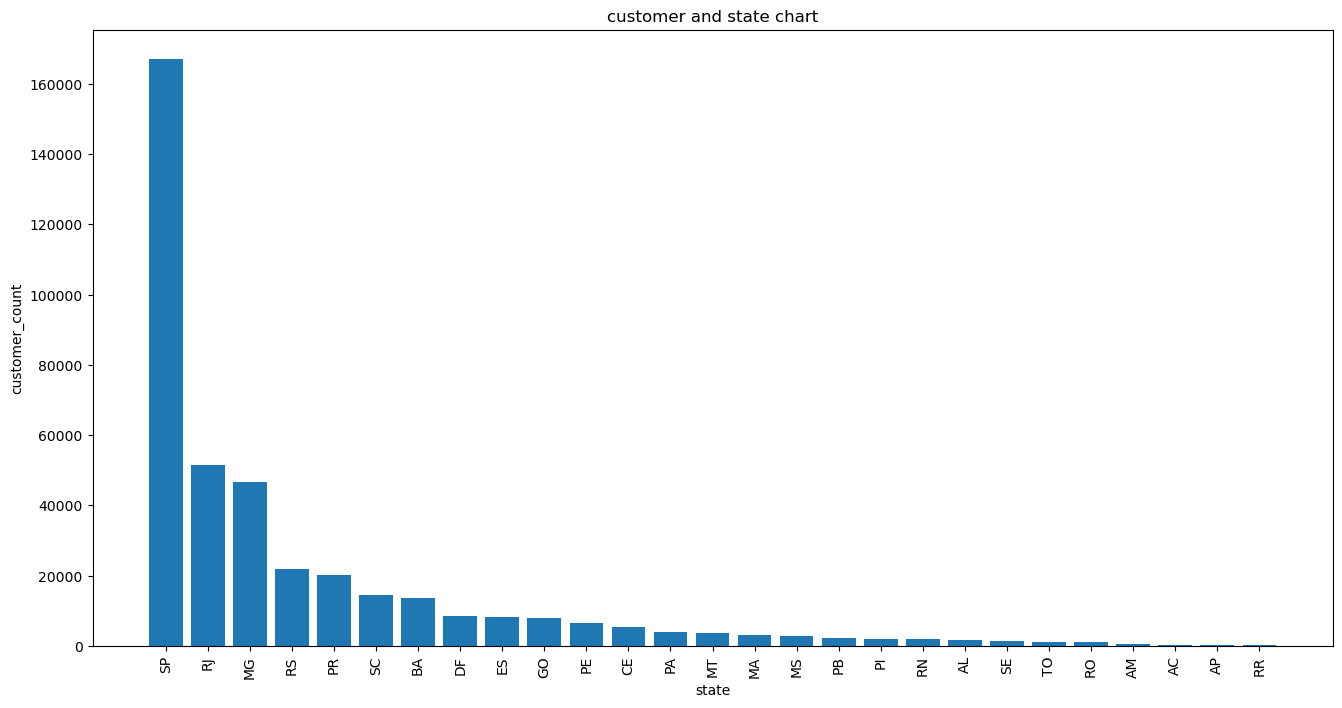

In [41]:
query="""select customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)
plt.figure(figsize=(16,8))
plt.bar(df["state"],df["customer_count"])
plt.xlabel("state",rotation=0)
plt.ylabel("customer_count",rotation=90)
plt.title("customer and state chart")
plt.xticks(rotation=90)
plt.show()


 # Calculate the number of orders per month in 2018

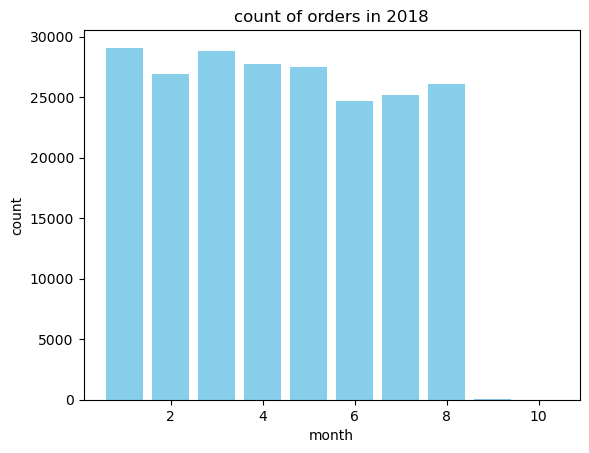

In [59]:
query="""select extract(MONTH from order_purchase_timestamp) as month,count(customer_id) as count from orders where extract(year from order_purchase_timestamp) = 2018 group by extract(MONTH from order_purchase_timestamp) order by month""" 
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["month","count"])
plt.bar(df["month"],df["count"],color="skyblue")
plt.xlabel("month")
plt.ylabel("count") 
plt.title("count of orders in 2018") 
plt.show()

 # Find the average number of products per order, grouped by customer city.

In [75]:
query="""with count_per_order as (select orders.order_id,orders.customer_id,
count(order_items.order_id) as oc 
from orders join order_items on
orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders 
from customers join count_per_order on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""
cur.execute(query)
data=cur.fetchall()
db=pd.DataFrame(data,columns=["city","avg_ord"])
db.head(20)


,city,avg_ord
0,padre carvalho,84.00
1,celso ramos,78.00
2,datas,72.00
3,candido godoi,72.00
4,matias olimpio,60.00
5,cidelandia,48.00
6,curralinho,48.00
7,picarra,48.00
8,morro de sao paulo,48.00
9,teixeira soares,48.00


# Calculate the percentage of total revenue contributed by each product category.

In [87]:
query="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value)
from payments))*100,2) sales_percentage
from products join order_items on products.product_id =order_items.product_id
join payments on payments.order_id =order_items.order_id 
group by upper(products.product_category)
order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","sales_percentage"])
df

,category,sales_percentage
0,BED TABLE BATH,128.37
1,HEALTH BEAUTY,124.23
2,COMPUTER ACCESSORIES,118.83
3,FURNITURE DECORATION,107.20
4,WATCHES PRESENT,107.13
...,...,...
69,PC GAMER,0.16
70,HOUSE COMFORT 2,0.13
71,CDS MUSIC DVDS,0.09
72,FASHION CHILDREN'S CLOTHING,0.06


# Identify the correlation between product price and the number of times a product has been purchased.

In [3]:
import numpy as np
query="""select products.product_category,count(order_items.product_id),
round(avg(order_items.price),2) from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","order_count","price"])
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased",a[0][1])




the correlation between product price and the number of times a product has been purchased -0.10631514167157559


 # Calculate the total revenue generated by each seller, and rank them by revenue

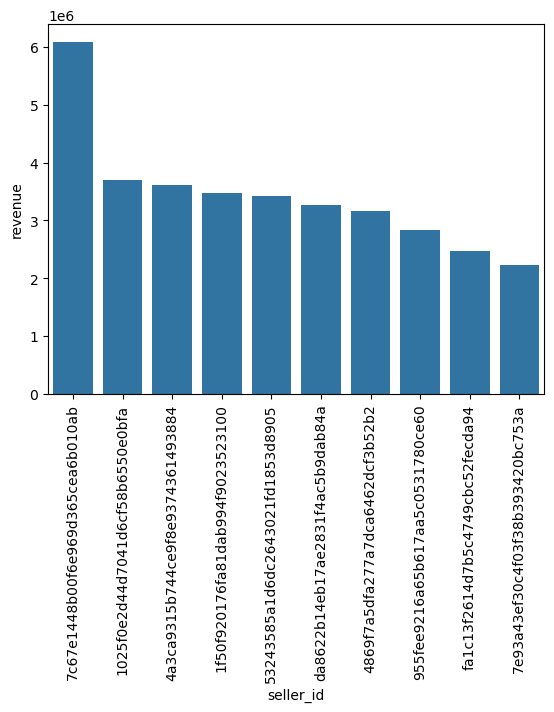

In [28]:
query="""select *,dense_rank() over(order by revenue desc) as rn from (select order_items.seller_id,
sum(payments.payment_value) revenue from order_items join payments on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head(10)
sns.barplot(x="seller_id",y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()

 # Calculate the moving average of order values for each customer over their order history.

In [21]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["customer_id", "order_purchase_timestamp"," payment","avg(payment)"])
df


,customer_id,order_purchase_timestamp,payment,avg(payment)
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
3636005,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3636006,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3636007,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3636008,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [23]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["years", "months" ," payment", "sum(payment)"])
df

,years,months,payment,sum(payment)
0,2016,9,8828.40,8.828400e+03
1,2016,10,2068166.80,2.076995e+06
2,2016,12,686.70,2.077682e+06
3,2017,1,4847081.40,6.924763e+06
4,2017,2,10216780.33,1.714154e+07
5,2017,3,15745225.98,3.288677e+07
6,2017,4,14622581.03,4.750935e+07
7,2017,5,20752158.70,6.826151e+07
8,2017,6,17894673.31,8.615618e+07
9,2017,7,20733402.18,1.068896e+08
